In [273]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


## Load data

In [82]:
df = pd.read_csv('./../error_dfs/error_2019.csv', converters={'ags2': str, 'ags5': str} )

In [83]:
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])

In [85]:
# add 'ags2','bundesland','kreis'
df2 = pd.read_csv('./../corona_data_sets/oeffentliche_finanzen.csv', converters={'ags2': str, 'ags5': str} )
df = pd.merge(df, df2[['ags2','ags5','bundesland','kreis']])
df

,ags5,date,ground_truth,pred,error,ags2,bundesland,kreis
0,01001,2019-01-31,8.2,7.801405,0.398595,01,Schleswig-Holstein,"Flensburg, Stadt"
1,01001,2019-02-28,7.8,8.052910,0.252910,01,Schleswig-Holstein,"Flensburg, Stadt"
2,01001,2019-03-31,7.8,7.763520,0.036480,01,Schleswig-Holstein,"Flensburg, Stadt"
3,01001,2019-04-30,7.6,7.634104,0.034104,01,Schleswig-Holstein,"Flensburg, Stadt"
4,01001,2019-05-31,7.7,7.337496,0.362504,01,Schleswig-Holstein,"Flensburg, Stadt"
...,...,...,...,...,...,...,...,...
4807,16077,2019-08-31,7.0,6.978600,0.021400,16,Thüringen,Altenburger Land
4808,16077,2019-09-30,6.5,6.839895,0.339895,16,Thüringen,Altenburger Land
4809,16077,2019-10-31,6.5,6.451817,0.048183,16,Thüringen,Altenburger Land
4810,16077,2019-11-30,6.3,6.556410,0.256410,16,Thüringen,Altenburger Land


## Plot each variable

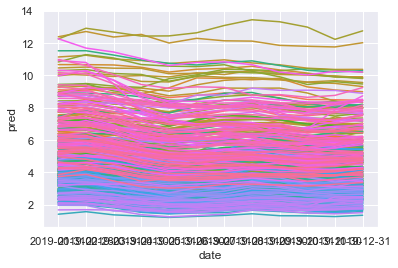

In [86]:
g = sns.lineplot(data=df, x="date", y="pred",  hue="ags5")
g.legend_.remove()

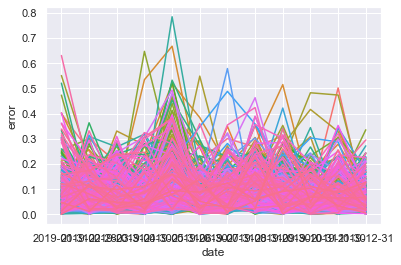

In [87]:
g = sns.lineplot(data=df, x="date", y="error",  hue="ags5")
g.legend_.remove()

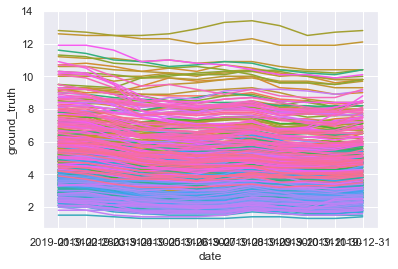

In [88]:
g = sns.lineplot(data=df, x="date", y="ground_truth",  hue="ags5")
g.legend_.remove()

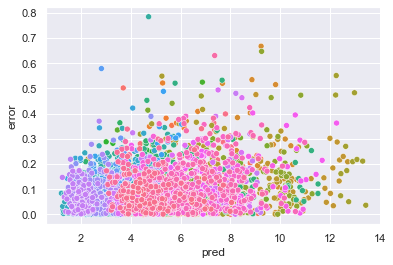

In [323]:
g = sns.scatterplot(data=df, x="pred", y="error",  hue="ags5")
g.legend_.remove()

## Plot sample to compare prediction to ground truth

In [90]:
df_long = df.melt(id_vars=['date','ags5','ags2','bundesland','kreis'], var_name='y_type', value_name='vals')

In [91]:
df_long = df_long[df_long['y_type'].isin(['ground_truth','pred'])]

In [315]:
sample_args = random.sample(list(set(df_long['ags5'])), 30)
df_sample = df_long[df_long['ags5'].isin(sample_args)]

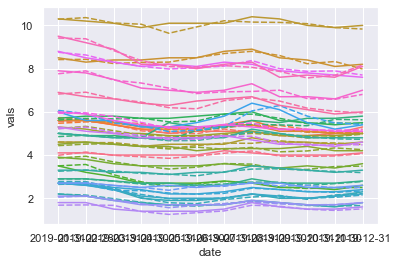

In [316]:
g = sns.lineplot(data=df_sample, x="date", y="vals",  hue="ags5", style="y_type")
g.legend_.remove()

## Look into mean errors

In [100]:
df_mean_error = df.groupby(['ags5','ags2','bundesland','kreis']).mean()
df_mean_error              

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
01001,01,Schleswig-Holstein,"Flensburg, Stadt",7.958333,7.853025,0.210342
01002,01,Schleswig-Holstein,"Kiel, Landeshauptstadt",7.591667,7.579645,0.118261
01003,01,Schleswig-Holstein,"Lübeck, Hansestadt",7.275000,7.274474,0.095788
01004,01,Schleswig-Holstein,"Neumünster, Stadt",7.900000,7.881733,0.090659
01051,01,Schleswig-Holstein,Dithmarschen,5.500000,5.489077,0.058198
...,...,...,...,...,...,...
16073,16,Thüringen,Saalfeld-Rudolstadt,5.241667,5.257047,0.085753
16074,16,Thüringen,Saale-Holzland-Kreis,4.141667,4.142775,0.095621
16075,16,Thüringen,Saale-Orla-Kreis,4.600000,4.630328,0.088846


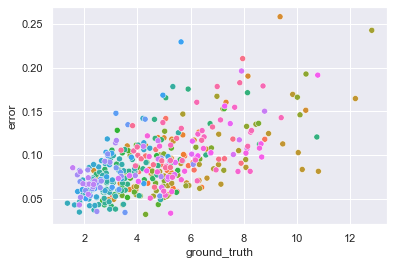

In [101]:
g = sns.scatterplot(data=df_mean_error, x="ground_truth", y="error",  hue="ags5")
g.legend_.remove()

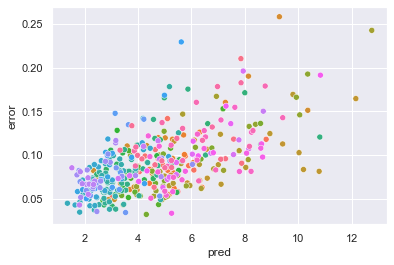

In [102]:
g = sns.scatterplot(data=df_mean_error, x="pred", y="error",  hue="ags5")
g.legend_.remove()

In [103]:
df_mean_error.sort_values(by = ['error'], ascending=False)

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
03401,03,Niedersachsen,Delmenhorst,9.366667,9.295457,0.258285
05513,05,Nordrhein-Westfalen,Gelsenkirchen,12.816667,12.759603,0.242698
09464,09,Freistaat Bayern,Hof,5.641667,5.616806,0.229453
01001,01,Schleswig-Holstein,"Flensburg, Stadt",7.958333,7.853025,0.210342
12053,12,Brandenburg,Frankfurt (Oder),7.916667,7.938185,0.196126
...,...,...,...,...,...,...
09673,09,Freistaat Bayern,Rhön-Grabfeld,2.475000,2.453493,0.035406
09175,09,Freistaat Bayern,Ebersberg,1.816667,1.807418,0.034685
09562,09,Freistaat Bayern,Erlangen,3.533333,3.527779,0.034256


<AxesSubplot:xlabel='error', ylabel='Density'>

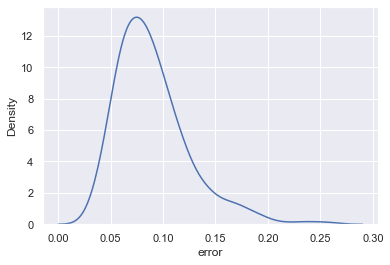

In [198]:
sns.kdeplot(data=df_mean_error, x="error", common_norm=False)

<AxesSubplot:xlabel='error', ylabel='Density'>

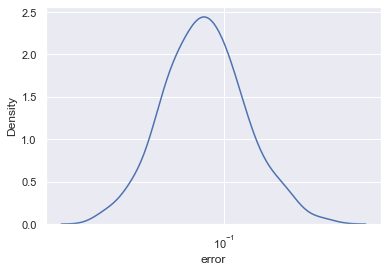

## Look into errors

In [104]:
df.sort_values(by = ['error'], ascending=False)

,ags5,date,ground_truth,pred,error,ags2,bundesland,kreis
2356,08222,2019-05-31,5.5,4.715860,0.784140,08,Baden-Württemberg,Mannheim
532,03401,2019-05-31,9.9,9.232759,0.667241,03,Niedersachsen,Delmenhorst
1275,05914,2019-04-30,9.9,9.253225,0.646775,05,Nordrhein-Westfalen,Hagen
4620,16062,2019-01-31,8.0,7.369784,0.630216,16,Thüringen,Nordhausen
3318,09476,2019-07-31,3.4,2.821355,0.578645,09,Freistaat Bayern,Kronach
...,...,...,...,...,...,...,...,...
1653,06632,2019-10-31,3.4,3.400248,0.000248,06,Hessen,Hersfeld-Rotenburg
661,03457,2019-02-28,5.9,5.899752,0.000248,03,Niedersachsen,Leer
2813,09180,2019-06-30,2.2,2.200169,0.000169,09,Freistaat Bayern,Garmisch-Partenkirchen
4584,16055,2019-01-31,6.3,6.300128,0.000128,16,Thüringen,Weimar


In [105]:
df['diff_ground_truth'] = df.groupby('ags5')['ground_truth'].diff(1) 
df['diff_ground_truth_abs'] = df['diff_ground_truth'].abs()

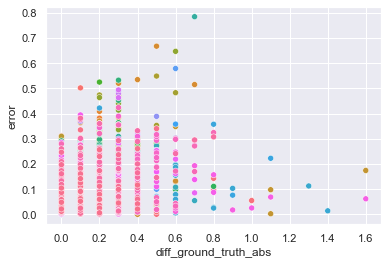

In [106]:
g = sns.scatterplot(data=df, x="diff_ground_truth_abs", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='error', ylabel='Density'>

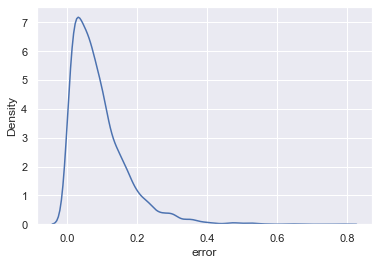

In [203]:
sns.kdeplot(data=df, x="error", common_norm=False)

<AxesSubplot:xlabel='error', ylabel='Density'>

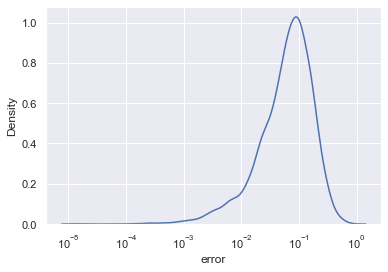

In [204]:
sns.kdeplot(data=df, x="error", common_norm=False,log_scale=True)

# Load structural data

In [119]:
df_structural = pd.read_csv('./../final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )
df_structural

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_/_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
0,0,"Flensburg, Stadt",01001,01,92,500,35,240,2901,240,...,2,4,3,2,99,99,1,1,C,1
1,2,"Kiel, Landeshauptstadt",01002,01,92,460,37,268,2037,265,...,2,1,2,1,99,99,1,0,C/D,1
2,2,"Lübeck, Hansestadt",01003,01,90,532,37,297,1927,294,...,1,1,2,1,5,99,1,0,C/D,1
3,0,"Neumünster, Stadt",01004,01,85,588,37,316,1648,313,...,2,3,2,2,5,99,1,0,D,1
4,0,Dithmarschen,01051,01,51,1864,35,448,3517,443,...,4,4,3,2,5,99,1,0,C,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0,Saalfeld-Rudolstadt,16073,16,62,1423,37,341,2492,322,...,3,4,2,2,99,99,2,0,C*,1
397,0,Saale-Holzland-Kreis,16074,16,54,1677,38,343,3419,340,...,3,3,2,2,99,99,2,0,C*,1
398,0,Saale-Orla-Kreis,16075,16,54,1686,35,449,3172,444,...,3,4,2,2,99,99,2,2,C*,1
399,0,Greiz,16076,16,55,1654,38,608,2779,563,...,3,2,2,1,99,99,2,0,C*,1


### Merge to df with mean errors

In [239]:
df_mixed = pd.merge(df_mean_error, df_structural, on = ['ags5','ags2'])
list(df_mixed.columns)

['ags5',
 'ags2',
 'ground_truth',
 'pred',
 'error',
 'cluster',
 'kreis',
 'supermarkets_population',
 'supermarkets_average_distance',
 'public_transport_availability',
 'average_distance_bus_stop',
 'average_distance_train_station',
 'average_distance_public_transport',
 'Unnamed:_0',
 'number_of_students',
 'number_of_hospitals',
 'number_of_hospital_beds',
 'number_of_hospital_beds_adj',
 'hospital_patiants',
 'households_of_1_person',
 'households_of_2_person',
 'households_of_3_person',
 'households_of_4_person',
 'households_of_5_person_or_more',
 'household_with_kids',
 'household_with_kids_under_3',
 'household_with_kids_over_3_under_6',
 'household_with_kids_over_6_under_10',
 'household_with_kids_over_10_under_15',
 'household_with_kids_over_15_under_18',
 'household_with_double_income_no_kids',
 'car_density',
 'no_of_paths_per_person_and_day',
 'kilometers_per_person_and_day',
 '_percentage_out_of_home',
 'share_of_journeys_on_foot',
 'share_of_journeys_on_bike',
 'propo

### Compare error in two_groups

In [173]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    df[column_name] = df[column_name].astype(str)
    one, two = list(set(df[column_name]))
    df_one = df[df[column_name]==one]
    df_two = df[df[column_name]==two]
    return ttest_ind(df_one['error'], df_two['error'], equal_var=False)

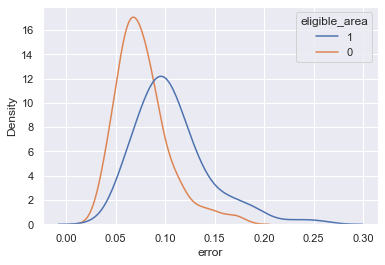

Ttest_indResult(statistic=-8.607252182961957, pvalue=5.091778629047658e-16)

In [174]:
compare_error_in_two_groups(df_mixed, 'eligible_area')

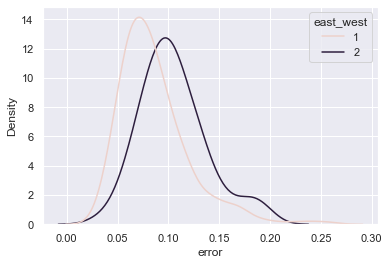

Ttest_indResult(statistic=4.474059045710493, pvalue=1.762248993054819e-05)

In [175]:
compare_error_in_two_groups(df_mixed, 'east_west')

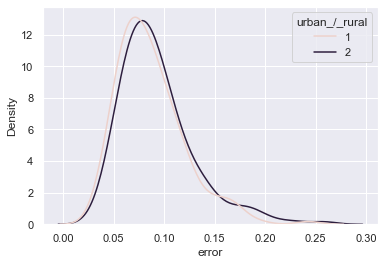

Ttest_indResult(statistic=-1.693760249351441, pvalue=0.09109470182985409)

In [176]:
compare_error_in_two_groups(df_mixed, 'urban_/_rural')

### Compare compare error in multiple groups

In [188]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    mod = ols(f'error ~ {column_name}',
                data=df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)

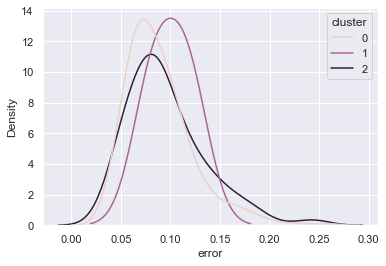

            sum_sq     df         F    PR(>F)
cluster   0.002859    1.0  2.293594  0.130701
Residual  0.497380  399.0       NaN       NaN


In [190]:
compare_error_in_two_groups(df_mixed, "cluster")

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


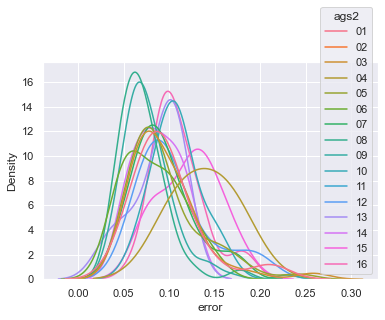

            sum_sq     df         F        PR(>F)
ags2      0.072533   15.0  4.352694  1.498724e-07
Residual  0.427706  385.0       NaN           NaN


In [191]:
compare_error_in_two_groups(df_mixed, "ags2")

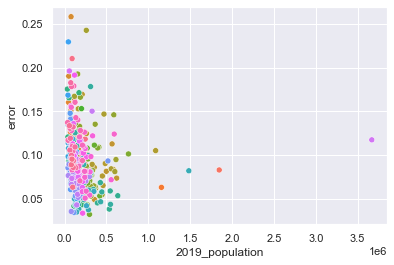

In [194]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

In [ ]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

### Linear Regression

In [243]:
df_mixed.set_index('ags5', drop=True, inplace=True)

In [247]:
df_mixed['east_west'] = df_mixed['east_west'].astype(str)
df_mixed['eligible_area'] = df_mixed['eligible_area'].astype(str)
df_mixed['cluster'] = df_mixed['cluster'].astype(str)
df_mixed['urban_/_rural'] = df_mixed['urban_/_rural'].astype(str)

X = df_mixed.drop(['kreis','pred','error','ground_truth','Unnamed:_0'], axis=1)
Y = np.log(df_mixed['error'])

X = pd.get_dummies(data=X, drop_first=True)

In [248]:
regr = LinearRegression()
regr.fit(X, Y, sample_weight=None)

LinearRegression()

In [249]:
stats.summary(regr, X, Y, X.columns)

Residuals:
   Min      1Q  Median     3Q    Max
-0.602 -0.1207 -0.0217 0.1192 0.7317


Coefficients:
                                                    Estimate                  Std. Error          t value   p value
_intercept                                       -154.929031  2.316904e+05+1.200000e-05j  -0.0007+0.0000j  0.999467
supermarkets_population                             0.007148  3.660000e-03+3.828000e-03j   0.9326-0.9754j  0.177945
supermarkets_average_distance                       0.000087  2.600000e-03+4.580000e-04j   0.0323-0.0057j  0.973815
public_transport_availability                       0.001616  1.689000e-03+8.000000e-05j   0.9547-0.0454j  0.339767
average_distance_bus_stop                           0.000254  2.360000e-04-1.000000e-05j   1.0729+0.0446j  0.283569
average_distance_train_station                      0.000011  5.600000e-05+2.000000e-06j   0.2003-0.0058j  0.841300
average_distance_public_transport                  -0.000272  3.590000e-04+1.200000e-05

### Sequential Feature Selector

In [260]:
sfs1 = sfs(regr, k_features = 10,forward=True, floating=False, scoring='r2', cv=5)
sfs1.fit(X, Y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=10,
                          scoring='r2')

In [311]:
summary_table_select = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
summary_table_select

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(150,)","[0.3220342717250645, 0.31046100919565667, 0.28...",0.254637,"(purchasing_power_per_household,)",0.085344,0.066401,0.0332
2,"(150, 152)","[0.34602120985294327, 0.3758963265019486, 0.41...",0.313643,"(purchasing_power_per_household, debtor_quota)",0.10829,0.084253,0.042126
3,"(69, 150, 152)","[0.38321792890647854, 0.3341682944258302, 0.46...",0.351077,"(Number_of_Commuters_on_place_of_residence), p...",0.088082,0.068531,0.034265
4,"(69, 142, 150, 152)","[0.40723198283816253, 0.3220624335802921, 0.47...",0.364437,"(Number_of_Commuters_on_place_of_residence), m...",0.087341,0.067955,0.033977
5,"(69, 142, 150, 152, 163)","[0.4250726923971049, 0.32457882877180677, 0.47...",0.3812,"(Number_of_Commuters_on_place_of_residence), m...",0.081558,0.063455,0.031727
6,"(69, 77, 142, 150, 152, 163)","[0.4336087227560974, 0.34336353128168096, 0.47...",0.392184,"(Number_of_Commuters_on_place_of_residence), n...",0.072261,0.056222,0.028111
7,"(69, 77, 80, 142, 150, 152, 163)","[0.4350519451340984, 0.3085669867144646, 0.497...",0.402672,"(Number_of_Commuters_on_place_of_residence), n...",0.08544,0.066475,0.033238
8,"(69, 77, 80, 123, 142, 150, 152, 163)","[0.4375904596962312, 0.3342781204062526, 0.505...",0.409854,"(Number_of_Commuters_on_place_of_residence), n...",0.076966,0.059882,0.029941
9,"(69, 77, 80, 123, 142, 150, 152, 160, 163)","[0.41301273417591955, 0.3428226707480546, 0.51...",0.423133,"(Number_of_Commuters_on_place_of_residence), n...",0.07217,0.05615,0.028075
10,"(69, 76, 77, 80, 123, 142, 150, 152, 160, 163)","[0.41734189515667786, 0.34859550032007247, 0.5...",0.430387,"(Number_of_Commuters_on_place_of_residence), C...",0.067869,0.052804,0.026402


In [318]:
list(summary_table_select['feature_names'])[:5]

[('purchasing_power_per_household',),
 ('purchasing_power_per_household', 'debtor_quota'),
 ('Number_of_Commuters_on_place_of_residence)',
  'purchasing_power_per_household',
  'debtor_quota'),
 ('Number_of_Commuters_on_place_of_residence)',
  'moor_area_percentage',
  'purchasing_power_per_household',
  'debtor_quota'),
 ('Number_of_Commuters_on_place_of_residence)',
  'moor_area_percentage',
  'purchasing_power_per_household',
  'debtor_quota',
  'settlement_structure_type_of_labor_market_region')]

### Ridge

In [286]:
rr = Ridge(alpha=0.5) 
rr.fit(X, Y)

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.95493e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge(alpha=0.5)

In [287]:
stats.summary(rr, X, Y, X.columns)

Residuals:
   Min      1Q  Median     3Q    Max
-0.612 -0.1245 -0.0228 0.1282 0.6891


Coefficients:
                                                   Estimate                  Std. Error          t value   p value
_intercept                                       -11.253235  2.347492e+05+1.100000e-05j  -0.0000+0.0000j  0.999962
supermarkets_population                            0.007800  6.157000e-03+0.000000e+00j   1.2668-0.0000j  0.205972
supermarkets_average_distance                      0.000106  2.550000e-03+0.000000e+00j   0.0414-0.0000j  0.966980
public_transport_availability                      0.000330  2.537000e-03-0.000000e+00j   0.1300+0.0000j  0.896633
average_distance_bus_stop                          0.000254  1.900000e-04+1.000000e-06j   1.3353-0.0077j  0.182521
average_distance_train_station                     0.000010  2.100000e-05+4.000000e-06j   0.4597-0.0897j  0.639745
average_distance_public_transport                 -0.000287  2.710000e-04+1.000000e-06j  -1.05

household_with_kids  
public_transport_per_1000_inhabitants 
number_of_companies_repair_motor_vehicles 
number_of_companies_hospitality
number_of_companies_technical_services
debtor_quota
purchasing_power_per_household

## Look at the variables that are important for predicting the error

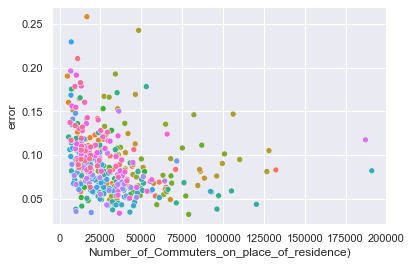

In [295]:
g = sns.scatterplot(data=df_mixed, x="Number_of_Commuters_on_place_of_residence)", y="error",  hue="ags5")
g.legend_.remove()

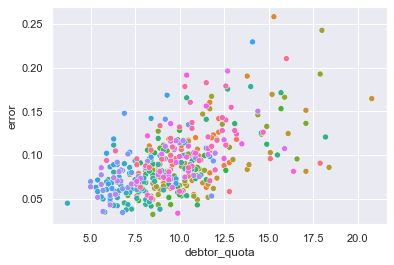

In [290]:
g = sns.scatterplot(data=df_mixed, x="debtor_quota", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='debtor_quota', ylabel='Density'>

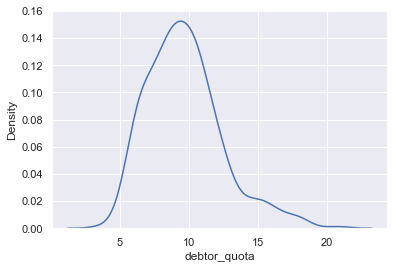

In [321]:
sns.kdeplot(data=df_mixed, x="debtor_quota", common_norm=False)

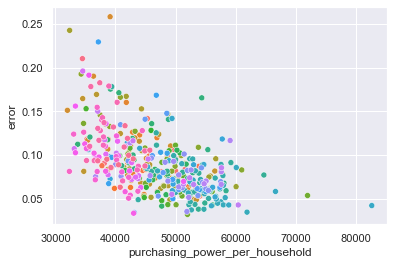

In [291]:
g = sns.scatterplot(data=df_mixed, x="purchasing_power_per_household", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='purchasing_power_per_household', ylabel='Density'>

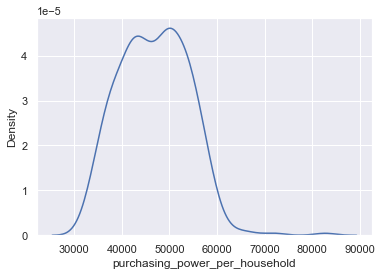

In [322]:
sns.kdeplot(data=df_mixed, x="purchasing_power_per_household", common_norm=False)

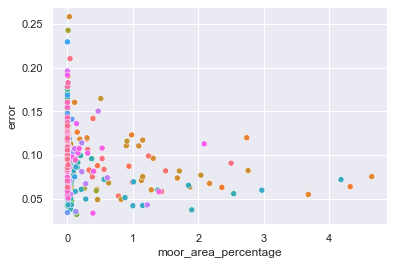

In [308]:
g = sns.scatterplot(data=df_mixed, x="moor_area_percentage", y="error",  hue="ags5")
g.legend_.remove()